# Table of Contents 
[Libraries Used](#libraries) 

Part I: [Read Data and EDA](#prelim)

Part II: [Feature selection and importance](#featureselection)

Part III: [Model selection and data training](#modelselection)

Part IV: [Hyperparameter optimization of best model](#hyperparameter)

Part V: [Employing XGBoost Regression - Best model](#bestmodelp)

Part VI: [Predictions with designed ML model - Out of sample](#makeprediction1)

In [4]:
#Import Libraries

#General libs
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy import sort

# SKlearn libraries for learning.
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, RepeatedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import ShuffleSplit, cross_validate, train_test_split
from sklearn import linear_model 
from xgboost import XGBRegressor
import xgboost as xgb
import lightgbm as lgbm

# SKlearn libraries for evaluation.
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
from sklearn.feature_selection import SelectFromModel

%matplotlib inline

# Control the hyperparameter optimization for the best model. It can be expensive
hyperparam_opt=False

#Set to true to download figures
savefigs=False

<a id='prelim'></a>

## Part I: Read Data and EDA

## Loading data

In [5]:
oneT_0K = pd.read_csv('2DH-data/1T0K-Mechanicalppts.txt', index_col = 0, delimiter = ',')
oneT_300K = pd.read_csv('2DH-data/1T300K-Mechanicalppts.txt', index_col = 0, delimiter = ',')
oneT_600K = pd.read_csv('2DH-data/1T600K-Mechanicalppts.txt', index_col = 0, delimiter = ',')

twoH_0K = pd.read_csv('2DH-data/2H0K-Mechanicalppts.txt', index_col = 0, delimiter = ',')
twoH_300K = pd.read_csv('2DH-data/2H300K-Mechanicalppts.txt', index_col = 0, delimiter = ',')
twoH_600K = pd.read_csv('2DH-data/2H600K-Mechanicalppts.txt', index_col = 0, delimiter =',')

twoone_0K = pd.read_csv('2DH-data/2H1T0K-Mechanicalppts.txt', index_col = 0, delimiter = ',')
twoone_300K = pd.read_csv('2DH-data/2H1T300K-Mechanicalppts.txt', index_col = 0, delimiter = ',')

P_0K = pd.read_csv('2DH-data/P0K-Mechanicalppts.txt', index_col = 0, delimiter = ',')
P_300K = pd.read_csv('2DH-data/P300K-Mechanicalppts.txt', index_col = 0, delimiter = ',')
P_600K = pd.read_csv('2DH-data/P600K-Mechanicalppts.txt', index_col = 0, delimiter =',')


In [6]:
datas = [oneT_0K, twoH_0K, twoone_0K, P_0K, oneT_300K, twoH_300K, twoone_300K, P_300K, oneT_600K, twoH_600K, P_600K]
Fullset= pd.concat(datas)
Fullset.describe()

,a,b,c,SG,C11,C12,Y_2D_a,Y_2D_b,G_a,G_b,B_a,B_b,V_a,V_b,aa,bb,cc
count,6654.000000,6654.000000,6654.000000,9171.000000,9166.000000,9166.000000,9166.000000,9166.000000,9166.000000,9166.000000,9166.000000,9166.000000,9166.000000,2512.000000,2517.000000,2517.000000,2517.000000
mean,5.086940,5.091577,18.849509,38.251772,100.786024,4.731174,167.845443,168.216552,47.871787,48.096763,53.056998,52.792533,0.459607,0.208149,6.845177,6.845177,18.582420
std,1.795289,1.799328,3.084972,66.004020,960.949524,3172.990189,9691.662391,9691.563816,1109.733424,1109.713999,2065.263317,2065.124869,8.483219,8.350377,0.823542,0.823542,3.154251
min,2.733000,2.790000,6.578000,1.000000,-91270.750000,-303657.290000,-84520.030000,-84520.030000,-1043.580000,-468.250000,-197464.020000,-197464.020000,-182.660000,-182.660000,5.092000,5.092000,5.212000
25%,3.328000,3.325000,16.853000,1.000000,43.887500,13.842500,29.532500,29.330000,10.930000,10.882500,32.012500,32.087500,0.200000,0.150000,6.308000,6.308000,16.515000
50%,4.901000,4.901000,18.920500,1.000000,118.050000,42.505000,95.825000,95.935000,35.355000,35.460000,81.930000,82.140000,0.360000,0.360000,6.674000,6.674000,18.675000
75%,6.646000,6.649000,21.035500,8.000000,181.747500,71.317500,162.755000,162.767500,62.387500,62.580000,125.820000,125.830000,0.620000,0.680000,7.153000,7.153000,20.828000
max,10.766000,10.766000,27.118000,156.000000,1214.090000,1235.740000,918995.400000,918995.400000,106193.270000,106193.270000,1732.310000,1224.910000,486.450000,207.500000,10.769000,10.769000,26.875000


### Cleaning data
* SG is assumed to remain constant with temperature
* Only stable materials are included (C11>0 and C11>C12)
* Column of temperature is added
* Only materials where a = b are included

In [7]:
oneT_0K = oneT_0K[['a', 'b', 'c', 'SG', 'C11', 'C12']]
oneT_0K['Phase'] = '1T' 
oneT_0K['Temp'] = '0K'

## Considering only physical solutions (C11>0 and C11>C12) and systems where a = b.
oneT_0K = oneT_0K[(oneT_0K['C11']> 0) & (oneT_0K['C11']>oneT_0K['C12']) & (oneT_0K['a']==oneT_0K['b']) ]   

#display(oneT_0K)

/Users/sriharik/miniconda3/envs/nano281/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/sriharik/miniconda3/envs/nano281/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
oneT_300K = oneT_300K[['a', 'b', 'c', 'SG', 'C11', 'C12']]
oneT_300K = oneT_300K[(oneT_300K['C11']> 0) & (oneT_300K['C11']>oneT_300K['C12']) & (oneT_300K['a']==oneT_300K['b']) ]
oneT_300K['a'] = oneT_300K['a']/2
oneT_300K['Phase'] = '1T' 
oneT_300K['Temp'] = '300K'

## SG in temperature dependent calculations are assumed to be the same as that for 0K. 
oneT_300K['SG'].replace(1.0, 156, True)

#display(oneT_300K)

In [9]:
#oneT_600K.drop(labels=['Y_2D_a', 'Y_2D_b', 'G_a', 'G_b', 'B_a', 'B_b', 'V_a', 'V_b'], axis = 'columns', inplace = True)
oneT_600K.rename(columns={"aa" : "a", "bb" : "b", "cc" : "c"}, inplace = True)
oneT_600K = oneT_600K[['a', 'b', 'c', 'SG', 'C11', 'C12']]
oneT_600K = oneT_600K[(oneT_600K['C11']> 0) & (oneT_600K['C11']>oneT_600K['C12']) & (oneT_600K['a']==oneT_600K['b']) ]
oneT_600K['a'] = oneT_600K['a']/2
oneT_600K['Phase'] = '1T' 
oneT_600K['Temp'] = '600K'
oneT_600K['SG'].replace(1.0, 156, True)

#display(oneT_600K)

In [10]:
twoH_0K = twoH_0K[['a', 'b', 'c', 'SG', 'C11', 'C12']]
twoH_0K['Phase'] = '2H'
twoH_0K['Temp'] = '0K'

#display(twoH_0K)

/Users/sriharik/miniconda3/envs/nano281/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/sriharik/miniconda3/envs/nano281/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
twoH_300K = twoH_300K[['a', 'b', 'c', 'SG', 'C11', 'C12']]
twoH_300K = twoH_300K[(twoH_300K['C11']> 0) & (twoH_300K['C11']>twoH_300K['C12']) & (twoH_300K['a']==twoH_300K['b']) ]
twoH_300K['a'] = twoH_300K['a']/2
twoH_300K['Phase'] = '2H'
twoH_300K['Temp'] = '300K'

## Replacing the SG in twoH_300K with the correct ones according to twoH_0K.
matSG_8 = twoH_0K.index[twoH_0K['SG'] == 8].tolist()
notPresent = ['Hf-Ti-Te-Se', 'Pb-Sn-Te-Se', 'Ti-Hf-Se-Te', 'Si-Hf-Se-Te', 'Si-Hf-S-Se', 'Sn-Ge-Te-Se', 'Mo-Sn-S-Se', 'Hf-Si-Te-Se', 'Pb-Si-Se-Te', 'Sn-Si-S-Te', 'Hf-Sn-Se-S', 'Hf-Ge-Se-Te', 'Cr-Ti-Se-Te', 'Sn-Ge-Te-S', 'Sn-Hf-S-Se', 'Pb-Sn-Se-Te', 'Ti-Cr-Te-Se', 'Pb-Sn-S-Te', 'Pb-Mo-S-Se', 'Pb-Sn-Te-S', 'Sn-Mn-S-Se', 'Ge-Ti-Te-Se', 'Ge-Hf-Se-Te', 'Ti-Pb-S-Se','Ti-Mn-Te-Se', 'Mn-Ti-Se-Te', 'Pb-Ge-Te-O', 'Ge-Pb-Se-Te']

toRemove = [i for i in matSG_8]
for i in matSG_8:
    if i in notPresent:
        toRemove.remove(i)

twoH_300K.loc[toRemove, 'SG'] = 8

indexSG156 = twoH_300K.index[twoH_300K['SG'] == 1].tolist()
twoH_300K.loc[indexSG156, 'SG'] = 156

#display(twoH_300K)

In [12]:
twoH_600K.rename(columns={"aa" : "a", "bb" : "b", "cc" : "c"}, inplace = True)
twoH_600K = twoH_600K[['a', 'b', 'c', 'SG', 'C11', 'C12']]
twoH_600K = twoH_600K[(twoH_600K['C11']> 0) & (twoH_600K['C11']>twoH_600K['C12']) & (twoH_600K['a']==twoH_600K['b']) ]
twoH_600K['a'] = twoH_600K['a']/2
twoH_600K['Phase'] = '2H' 
twoH_600K['Temp'] = '600K'

twoH_600K['SG'].replace(1.0, 156, True)

#display(twoH_600K)

In [13]:
twoone_0K = twoone_0K[['a', 'b', 'c', 'SG', 'C11', 'C12']]
twoone_0K['Phase'] = '2H-1T'
twoone_0K['Temp'] = '0K'
twoone_0K = twoone_0K[(twoone_0K['C11']> 0) & (twoone_0K['C11']>twoone_0K['C12']) & (twoone_0K['a']==twoone_0K['b']) ]

#display(twoone_0K)

/Users/sriharik/miniconda3/envs/nano281/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/sriharik/miniconda3/envs/nano281/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
twoone_300K = twoone_300K[['a', 'b', 'c', 'SG', 'C11', 'C12']]
twoone_300K = twoone_300K[(twoone_300K['C11']> 0) & (twoone_300K['C11']>twoone_300K['C12']) & (twoone_300K['a']==twoone_300K['b']) ]
twoone_300K['a'] = twoone_300K['a']/2
twoone_300K['Phase'] = '2H-1T'
twoone_300K['Temp'] = '300K'

#display(twoone_300K)

In [15]:
P_0K = P_0K[['a', 'b', 'c', 'SG', 'C11', 'C12']]
P_0K = P_0K[(P_0K['C11']> 0) & (P_0K['C11']>P_0K['C12']) & (P_0K['a']==P_0K['b']) ]
P_0K['Phase'] = 'Planar'
P_0K['Temp'] = '0K'

#display(P_0K)

In [16]:
P_300K = P_300K[['a', 'b', 'c', 'SG', 'C11', 'C12']]
P_300K = P_300K[(P_300K['C11']> 0) & (P_300K['C11']>P_300K['C12']) & (P_300K['a']==P_300K['b']) ]
P_300K['a'] = P_300K['a']/2
P_300K['Phase'] = 'Planar'
P_300K['Temp'] = '300K'
P_300K['SG'].replace(1.0, 156, True)
#display(P_300K)

In [17]:
P_600K.rename(columns={"aa" : "a", "bb" : "b", "cc" : "c"}, inplace = True)
P_600K = P_600K[['a', 'b', 'c', 'SG', 'C11', 'C12']]
P_600K = P_600K[(P_600K['C11']> 0) & (P_600K['C11']>P_600K['C12']) & (P_600K['a']==P_600K['b']) ]
P_600K['a'] = P_600K['a']/2
P_600K['Phase'] = 'Planar' 
P_600K['Temp'] = '600K'
P_600K['SG'].replace(1.0, 156, True)

#display(P_600K)

In [18]:
datas = [oneT_0K, twoH_0K, twoone_0K, P_0K, oneT_300K, twoH_300K, twoone_300K, P_300K, oneT_600K, twoH_600K, P_600K]
dataset = pd.concat(datas)
del dataset["b"] #Note, we have trained the data for a=b, so, we remove the b column


In [19]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6436 entries, Cr-Ge-O-Se to Zn-Te-Sr-Se
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   a       6436 non-null   float64
 1   c       6436 non-null   float64
 2   SG      6436 non-null   float64
 3   C11     6436 non-null   float64
 4   C12     6436 non-null   float64
 5   Phase   6436 non-null   object 
 6   Temp    6436 non-null   object 
dtypes: float64(5), object(2)
memory usage: 402.2+ KB


In [20]:
display(dataset)

,a,c,SG,C11,C12,Phase,Temp
Material,,,,,,,
Cr-Ge-O-Se,3.2190,20.358,156.0,83.84,38.68,1T,0K
Cr-Ge-O-S,3.1640,21.068,156.0,213.20,84.54,1T,0K
Cr-Ge-Se-O,3.0220,23.092,156.0,235.61,49.62,1T,0K
Cr-Ge-Se-S,3.3320,18.996,156.0,140.26,3.52,1T,0K
Cr-Ge-Se-Te,3.2660,19.770,156.0,109.27,56.37,1T,0K
...,...,...,...,...,...,...,...
Zn-Te-Mg-O,3.6080,21.629,156.0,19.46,-16.31,Planar,600K
Zn-Te-Mg-S,4.1945,16.004,156.0,30.02,8.83,Planar,600K
Zn-Te-Sr-O,4.1610,16.265,156.0,0.62,-9.17,Planar,600K


#### Including rarely occuring SG values

Any space group number occuring less than 4 times is categorized arbitrarily as 0.

In [21]:
SG_in_model = dataset.SG.value_counts().reset_index(name="count").query("count > 4")["index"]

def replace_rare_SG_occurances(dataset):
    dataset.loc[~dataset["SG"].isin(SG_in_model), "SG"] = 0
    return dataset
    
replace_rare_SG_occurances(dataset)

,a,c,SG,C11,C12,Phase,Temp
Material,,,,,,,
Cr-Ge-O-Se,3.2190,20.358,156.0,83.84,38.68,1T,0K
Cr-Ge-O-S,3.1640,21.068,156.0,213.20,84.54,1T,0K
Cr-Ge-Se-O,3.0220,23.092,156.0,235.61,49.62,1T,0K
Cr-Ge-Se-S,3.3320,18.996,156.0,140.26,3.52,1T,0K
Cr-Ge-Se-Te,3.2660,19.770,156.0,109.27,56.37,1T,0K
...,...,...,...,...,...,...,...
Zn-Te-Mg-O,3.6080,21.629,156.0,19.46,-16.31,Planar,600K
Zn-Te-Mg-S,4.1945,16.004,156.0,30.02,8.83,Planar,600K
Zn-Te-Sr-O,4.1610,16.265,156.0,0.62,-9.17,Planar,600K


## Encoding of categorical features

In [22]:
encSG = LabelEncoder()
encT = LabelEncoder()
enc = [encSG, encT]
categorical_variables = ['SG','Temp']
for c, encoder in zip(categorical_variables, enc):
    print(f"Label Encoding: {c} - {dataset[c].nunique()}")
    encoder.fit(dataset[c])
    dataset[c] = encoder.transform(dataset[c])


Label Encoding: SG - 3
Label Encoding: Temp - 3


In [23]:
#merged = pd.concat([dataset, PhaseDummies], axis = 'columns')
finaldata = dataset.drop(labels='Phase', axis='columns')
finaldata

,a,c,SG,C11,C12,Temp
Material,,,,,,
Cr-Ge-O-Se,3.2190,20.358,2,83.84,38.68,0
Cr-Ge-O-S,3.1640,21.068,2,213.20,84.54,0
Cr-Ge-Se-O,3.0220,23.092,2,235.61,49.62,0
Cr-Ge-Se-S,3.3320,18.996,2,140.26,3.52,0
Cr-Ge-Se-Te,3.2660,19.770,2,109.27,56.37,0
...,...,...,...,...,...,...
Zn-Te-Mg-O,3.6080,21.629,2,19.46,-16.31,2
Zn-Te-Mg-S,4.1945,16.004,2,30.02,8.83,2
Zn-Te-Sr-O,4.1610,16.265,2,0.62,-9.17,2


<a id='featureselection'></a>

## Part II: Feature selection and feature importance

A simple correlation map is used to assess the correlation of different features with the target (a). In a typical ML problen we drop features based on this map to reduce the computation cost. We could have dropped some of these features on the basis of their weak correlation with 'a', but since this problem does not have too large a feature set we go ahead with all of them.

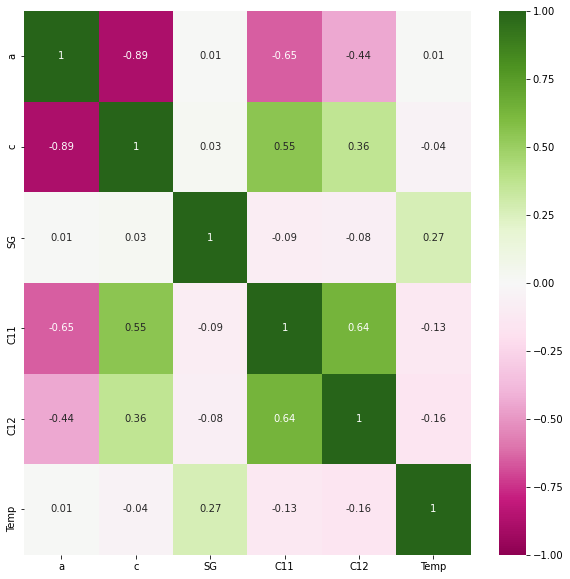

In [24]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(finaldata.corr(method = 'spearman').round(2), annot = True, cmap="PiYG", vmin=-1, vmax=1, ax=ax);

if savefigs==True: 
    f.savefig("Figures/CorrMap_H", dpi = 1200, transparent = False, facecolor = 'white')

<AxesSubplot:>

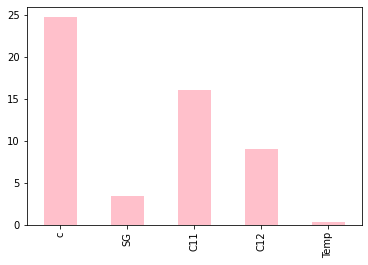

In [25]:
from sklearn.feature_selection import SelectKBest, f_regression

fea = [c for c in finaldata.columns if c!= "a"]
Ximp = finaldata[fea]
Yimp = finaldata["a"]
sel = SelectKBest(f_regression, k="all")
sel.fit_transform(Ximp, Yimp)
importance = sel.scores_
impGraph = pd.Series(np.cbrt(importance), Ximp.columns)
impGraph.plot.bar(color = "Pink")


For regression, the vacuum size 'c' of a system has the maximum importance followed by its C11 value and whether the structure is planar or not. It seems that temperature is not important for regression. This is also seen in the datasets where the lattice constant column has almost identical values for all three temepratures. 

In [26]:
## Drop one of the phase columns to avoid multi-collinearity. We drop 1T column.

#finaldata.drop('1T', axis = 'columns', inplace = True)
display(finaldata)

,a,c,SG,C11,C12,Temp
Material,,,,,,
Cr-Ge-O-Se,3.2190,20.358,2,83.84,38.68,0
Cr-Ge-O-S,3.1640,21.068,2,213.20,84.54,0
Cr-Ge-Se-O,3.0220,23.092,2,235.61,49.62,0
Cr-Ge-Se-S,3.3320,18.996,2,140.26,3.52,0
Cr-Ge-Se-Te,3.2660,19.770,2,109.27,56.37,0
...,...,...,...,...,...,...
Zn-Te-Mg-O,3.6080,21.629,2,19.46,-16.31,2
Zn-Te-Mg-S,4.1945,16.004,2,30.02,8.83,2
Zn-Te-Sr-O,4.1610,16.265,2,0.62,-9.17,2


<a id='modelselection'></a>

## Part III: Model selection and data training

## Remove 20% of the dataset as unseen data for out-of-sample test

In [27]:
data, data_test = train_test_split(finaldata, test_size = 0.2, random_state = 42)
data = pd.DataFrame(data)
data_test = pd.DataFrame(data_test)
display(data)
display(data_test)

,a,c,SG,C11,C12,Temp
Material,,,,,,
W-Cr-S-O,3.0150,23.210,2,254.74,43.39,0
Pb-W-Te-Se,3.2925,17.853,2,154.00,65.92,2
Ge-O-Mn-Te,3.1270,21.566,0,185.22,69.79,0
Be-Se-Zn-O,3.5340,22.542,2,116.61,36.02,0
Pb-Cr-Se-Te,3.7690,14.845,2,49.46,25.29,0
...,...,...,...,...,...,...
Mn-Si-Se-S,3.2280,18.576,2,172.83,70.06,1
Sn-Pb-Se-O,3.5870,16.391,2,58.60,11.56,2
Sn-W-Te-S,3.1900,20.725,2,180.50,97.23,2


,a,c,SG,C11,C12,Temp
Material,,,,,,
Mn-Ti-Te-Se,3.4805,15.975,2,69.13,4.33,2
Si-Mn-S-O,3.0865,22.141,2,244.71,84.34,1
Hf-Mo-O-Te,3.3070,19.284,2,267.12,52.37,0
Hf-Ge-S-Se,3.6835,14.265,2,68.31,12.40,1
Pb-Mn-O-Se,3.3550,18.737,2,126.53,50.09,2
...,...,...,...,...,...,...
Pb-Ge-S-Te,4.0395,11.861,2,36.87,-16.38,2
Ba-Te-Zn-S,5.2415,10.249,2,10.28,6.94,2
Ge-Pb-Te-Se,4.4720,10.545,2,37.61,16.58,0


### Define features and target

In [28]:
features = [c for c in data.columns if c!= "a"]
X = data[features]
y = data["a"]

## Linear Regression

Here we first do a simple train test split (7:3) followed by a cross validation test to assess the accuracy of a default Linear Regression model. 

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
lr = linear_model.LinearRegression()

kfold = KFold(n_splits = 5, shuffle = True, random_state = 42)
lr.fit(X_train, y_train)

#lr = linear_model.LinearRegression()
cv = RepeatedKFold(n_splits = 5, n_repeats = 3, random_state = 42)
scores = cross_val_score(lr, X, y, cv = cv)
r2_mean = scores.mean()
print("%0.4f accuracy with a standard deviation of %0.4f" % (r2_mean, scores.std()))
print(scores)

0.7389 accuracy with a standard deviation of 0.0091
[0.74088064 0.74896523 0.73241124 0.73518354 0.73903437 0.75477513
 0.7354315  0.73742042 0.73004429 0.73658397 0.740986   0.74344288
 0.71941025 0.73319384 0.7557975 ]


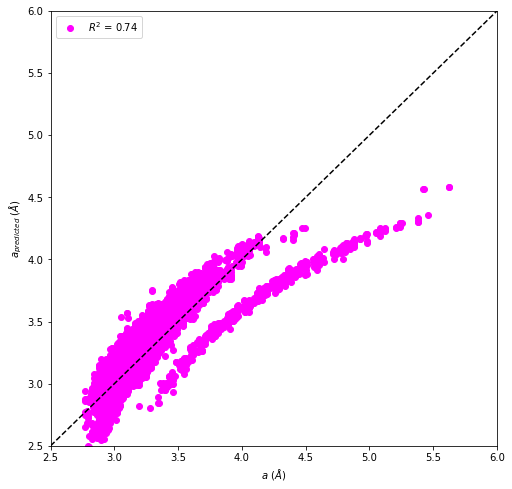

In [30]:
yhat_lr = cross_val_predict(lr, X, y, cv = kfold)

f, ax = plt.subplots(figsize=(8, 8))
label_mlr = "$R^2$ = %.2f" % r2_mean
plt.plot(y, yhat_lr, 'o', label=label_mlr, color = "magenta")
plt.ylabel(r"$a_{predicted}$ ($\AA$)")
plt.xlabel(r"$a$ ($\AA$)")
plt.legend()
plt.xlim([2.5, 6])
plt.ylim([2.5, 6])
plt.plot([2.5, 6], [2.5, 6], 'k--')
plt.show()

### Explore and search for the best model

In [31]:
#Lets use train/split ratio of 70/30 - Use ShuffleSplit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
#kfold = KFold(n_splits = 5, shuffle = True, random_state = 42 )

# Use some linear reg model and some with boosting capabilities

hyper_params_lgbm = {
    "objective" : "multiclass",
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'n_estimators': 500,
    "verbosity" : -1 
}

hyper_params_xgb = { 
    'objective': 'reg:squarederror',  # error evaluation for multiclass tasks
    'n_estimators': 500,
    'eval_metric': mean_absolute_error
    }
#Use ShuffleSplit for cross validation of dataset. Kfold also gives similar result
cv_split = ShuffleSplit(n_splits = 5, test_size = 0.30, random_state = 42)

# Initializing the Algorithms # I have tried a couple of them. Just showing a handful here
algorithm_list = {'LinearReg': linear_model.LinearRegression(), 
                  'BayeRidge':linear_model.BayesianRidge(),
                  'LassoLars': linear_model.LassoLars(alpha=0.01),
                  'LeastAngLars':linear_model.Lars(),
                  'XgbostReg': xgb.XGBRegressor(**hyper_params_xgb),
                  'LGBMReg': lgbm.LGBMRegressor(**hyper_params_lgbm)
                 }
# Fit the various model
for key,model in algorithm_list.items():
    try:
        if key == 'XgbostReg' or key == 'LGBMReg':
            model.fit(X_train, y_train,early_stopping_rounds=100,eval_set=[(X_test, y_test)])
        else:
            model.fit(X_train, y_train)
        # Cross-validate the result to avoid over fitting
        cv_results = cross_validate(model, X_train, y_train, cv  = cv_split)
#        cv_results = RepeatedKFold(n_splits = 5, n_repeats = 3, random_state = 42)
        adj_R2 = 1 - (1-model.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
        y_pred = model.predict(X_test) 
        # Print model and test metrics
        print(f'Model - {key: <5} || Model Score: %.3f, Adj_R^2: %.3f, Test Score: %.3f, Cross Val Score: %.3f' 
              %(model.score(X_train, y_train),adj_R2, model.score(X_test, y_test), cv_results.get('test_score').mean()))
        
        print(f'Model - {key: <5} || MSE: %.3f, MAE: %.3f, STD: %.3f, MAPE: %.3f%%' 
              %(metrics.mean_squared_error(y_test, y_pred), metrics.mean_absolute_error(y_test, y_pred), 
                cv_results.get('test_score').std(), metrics.mean_absolute_percentage_error(y_test, y_pred)*100))
        print(f'Model - {key: <5}  || Cross Validation Progress: \n')
        print(pd.DataFrame(cv_results))
        print('----------------------------------------------------------------------------------------------------------')
    except Exception as e:
        print(f"Exception occurred in {str(e)}")
        pass 

Model - LinearReg || Model Score: 0.738, Adj_R^2: 0.737, Test Score: 0.744, Cross Val Score: 0.741
Model - LinearReg || MSE: 0.041, MAE: 0.136, STD: 0.003, MAPE: 3.810%
Model - LinearReg  || Cross Validation Progress: 

   fit_time  score_time  test_score
0  0.003035    0.002197    0.742113
1  0.003259    0.001881    0.744727
2  0.002755    0.001712    0.740301
3  0.002916    0.001967    0.734974
4  0.003078    0.001866    0.743620
----------------------------------------------------------------------------------------------------------
Model - BayeRidge || Model Score: 0.738, Adj_R^2: 0.737, Test Score: 0.744, Cross Val Score: 0.741
Model - BayeRidge || MSE: 0.041, MAE: 0.136, STD: 0.003, MAPE: 3.809%
Model - BayeRidge  || Cross Validation Progress: 

   fit_time  score_time  test_score
0  0.003836    0.002066    0.742076
1  0.003558    0.002061    0.744759
2  0.003510    0.002081    0.740279
3  0.003237    0.001884    0.734929
4  0.003155    0.001976    0.743574
---------------------

/Users/sriharik/miniconda3/envs/nano281/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[74]	valid_0's l2: 0.0237095
[75]	valid_0's l2: 0.0237374
[76]	valid_0's l2: 0.0237694
[77]	valid_0's l2: 0.0237257
[78]	valid_0's l2: 0.0237741
[79]	valid_0's l2: 0.0237955
[80]	valid_0's l2: 0.0237886
[81]	valid_0's l2: 0.0238177
[82]	valid_0's l2: 0.0237935
[83]	valid_0's l2: 0.0237879
[84]	valid_0's l2: 0.0237852
[85]	valid_0's l2: 0.0237962
[86]	valid_0's l2: 0.0238293
[87]	valid_0's l2: 0.0238898
[88]	valid_0's l2: 0.0239379
[89]	valid_0's l2: 0.0239571
[90]	valid_0's l2: 0.0238979
[91]	valid_0's l2: 0.023911
[92]	valid_0's l2: 0.0238499
[93]	valid_0's l2: 0.023849
[94]	valid_0's l2: 0.023876
[95]	valid_0's l2: 0.0239174
[96]	valid_0's l2: 0.0239229
[97]	valid_0's l2: 0.0239738
[98]	valid_0's l2: 0.0240263
[99]	valid_0's l2: 0.0240588
[100]	valid_0's l2: 0.0240698
[101]	valid_0's l2: 0.0240437
[102]	valid_0's l2: 0.0240158
[103]	valid_0's l2: 0.0240523
[104]	valid_0's l2: 0.0240451
[105]	valid_0's l2: 0.0240442
[106]	valid_0's l2: 0.0240578
[107]	valid_0's l2: 0.0240862
[108]	val

### Comment on the ML models performance 
***The boosting models performed the best. We will adopt the Xgboost model***

<a id='hyperparameter'></a>

## Part IV: Hyperparameter Optimization of best model

In [32]:
if (hyperparam_opt==True):
    # Doing hyperparameter optimization

    from sklearn.model_selection import StratifiedShuffleSplit
    from sklearn import model_selection

    n_estimators = [int(x) for x in np.linspace(start =50, stop = 500, num = 5)]
    max_depth = [int(x) for x in np.linspace(start =5, stop = 20, num = 5)]
    #bootstrap = [True, False]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

    kfold = ShuffleSplit(n_splits = 5, test_size = 0.3, random_state = 42) 
    #KFold(n_splits = 10, shuffle = True, random_state = rng )

    param_grid = {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'objective':['reg:squarederror'],
        'learning_rate': [0.02, 0.04, 0.06, 0.08, 0.10],
        'colsample_bytree': [0.5, 0.6, 0.7, 0.8]
    }

    bestmodel = XGBRegressor()

    xgb_bestmodel = model_selection.GridSearchCV( 
        estimator=bestmodel,
        param_grid=param_grid,
        scoring="r2",
        n_jobs = 4,
        cv=kfold,
        verbose = True

    )

    xgb_bestmodel.fit(X_train, y_train)


    #bestparams = model.best_estimator_.get_params()
    bestparams = xgb_bestmodel.best_params_
    bestscore = xgb_bestmodel.best_score_

    print("Best paramters for the chosen model: %s " % bestparams)
    print("Best r2 score: %.6f " % bestscore)


In [33]:
'''
Best hyperparameter
Best paramters for the chosen model: {'colsample_bytree': 0.8, 'learning_rate': 0.02, 'max_depth': 8, 'n_estimators': 500, 'objective': 'reg:squarederror'} 
Best r2 score: 0.884865 
'''

"\nBest hyperparameter\nBest paramters for the chosen model: {'colsample_bytree': 0.8, 'learning_rate': 0.02, 'max_depth': 8, 'n_estimators': 500, 'objective': 'reg:squarederror'} \nBest r2 score: 0.884865 \n"

<a id='bestmodelp'></a>

## Part V: Employing XGBoost Regression - Best model 

In [34]:
# Use boosting model, which was the best of all the models tested
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

param_best = {'colsample_bytree': 0.8, 
              'learning_rate': 0.1, 
              'max_depth': 8, 
              'n_estimators': 500, 
              'objective': 'reg:squarederror'}

xgbr = XGBRegressor(**param_best)
xgbr.fit(X_train, y_train,early_stopping_rounds=100,eval_set=[(X_test, y_test)])
cv_results = cross_validate(xgbr, X_train, y_train, cv  = cv_split)

adj_R2_train = 1 - (1-model.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
adj_R2_test = 1 - (1-model.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
y_pred = xgbr.predict(X_test) 
R2_value = xgbr.score(X_test, y_test)
MSE = metrics.mean_squared_error(y_test, y_pred)
MAE = metrics.mean_absolute_error(y_test, y_pred)
MAPE = metrics.mean_absolute_percentage_error(y_test, y_pred)
        
print(f'Model Score: %.3f, Adj_R^2: %.3f, Test Score: %.3f, Cross Val Score: %.3f' 
      %(xgbr.score(X_train, y_train),adj_R2_train, xgbr.score(X_test, y_test), cv_results.get('test_score').mean()))
        
print(f'MSE: %.3f, MAE: %.3f, STD: %.3f, MAPE: %.3f%%' 
      %(MSE, MAE,cv_results.get('test_score').std(), MAPE*100))
        
print(f'Cross Validation Progress: \n')
print(pd.DataFrame(cv_results))

[0]	validation_0-rmse:2.62734
[1]	validation_0-rmse:2.36797
[2]	validation_0-rmse:2.13541
[3]	validation_0-rmse:1.92513
[4]	validation_0-rmse:1.73571
[5]	validation_0-rmse:1.56516
[6]	validation_0-rmse:1.41292
[7]	validation_0-rmse:1.27494
[8]	validation_0-rmse:1.15144
[9]	validation_0-rmse:1.03996
[10]	validation_0-rmse:0.94050
[11]	validation_0-rmse:0.85036
[12]	validation_0-rmse:0.77037
[13]	validation_0-rmse:0.69780
[14]	validation_0-rmse:0.63304
[15]	validation_0-rmse:0.57548
[16]	validation_0-rmse:0.52372
[17]	validation_0-rmse:0.47716
[18]	validation_0-rmse:0.43579
[19]	validation_0-rmse:0.39890
[20]	validation_0-rmse:0.36618
[21]	validation_0-rmse:0.33726
[22]	validation_0-rmse:0.31189
[23]	validation_0-rmse:0.28961
[24]	validation_0-rmse:0.26966
[25]	validation_0-rmse:0.25202
[26]	validation_0-rmse:0.23704
[27]	validation_0-rmse:0.22317
[28]	validation_0-rmse:0.21109
[29]	validation_0-rmse:0.20092
[30]	validation_0-rmse:0.19192
[31]	validation_0-rmse:0.18516
[32]	validation_0-

[260]	validation_0-rmse:0.13812
[261]	validation_0-rmse:0.13809
[262]	validation_0-rmse:0.13814
[263]	validation_0-rmse:0.13818
[264]	validation_0-rmse:0.13819
[265]	validation_0-rmse:0.13817
[266]	validation_0-rmse:0.13817
[267]	validation_0-rmse:0.13816
[268]	validation_0-rmse:0.13817
[269]	validation_0-rmse:0.13816
[270]	validation_0-rmse:0.13810
[271]	validation_0-rmse:0.13813
[272]	validation_0-rmse:0.13815
[273]	validation_0-rmse:0.13816
[274]	validation_0-rmse:0.13815
[275]	validation_0-rmse:0.13815
[276]	validation_0-rmse:0.13815
[277]	validation_0-rmse:0.13816
[278]	validation_0-rmse:0.13817
[279]	validation_0-rmse:0.13819
[280]	validation_0-rmse:0.13812
[281]	validation_0-rmse:0.13812
[282]	validation_0-rmse:0.13811
[283]	validation_0-rmse:0.13813
[284]	validation_0-rmse:0.13813
[285]	validation_0-rmse:0.13815
[286]	validation_0-rmse:0.13818
[287]	validation_0-rmse:0.13817
[288]	validation_0-rmse:0.13813
[289]	validation_0-rmse:0.13815
[290]	validation_0-rmse:0.13815
[291]	va

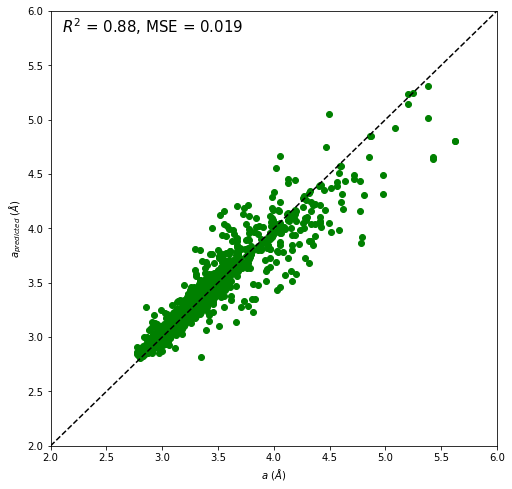

In [35]:
f, ax = plt.subplots(figsize=(8, 8))
#label_xgbr = f'$R^2$ = %.3f, Adj_$R^2$ = %.3f, \n MSE =  %.3f, MAE = %.3f' %(R2_value,adj_R2_test, MSE, MAE)    
plt.plot(y_test, y_pred, 'o', color = "green")
plt.ylabel(r"$a_{predicted}$ ($\AA$)")
plt.xlabel(r"$a$ ($\AA$)")
#plt.legend()
plt.xlim([2, 6])
plt.ylim([2, 6])
plt.plot([2, 6], [2, 6], 'k--')
plt.annotate(r"$R^2$ = %.2f, MSE = %.3f" % (R2_value, MSE), (2.1, 5.8), fontsize=15);
#plt.show()

if savefigs==True:
    f.savefig("Figures/BestModel_H", dpi = 1200, transparent = False, facecolor = 'white')

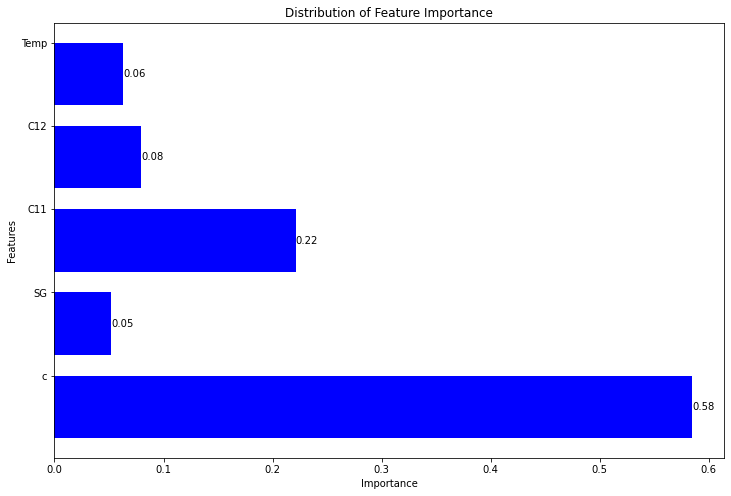

In [36]:
x = X_train.columns
y = xgbr.feature_importances_

fig, ax = plt.subplots(figsize=(12,8))    
width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color="blue")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
plt.title('Distribution of Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')

# Print the values on the barchart
ax.bar_label(ax.containers[0],label_type='edge',fmt='%.2f')

plt.show()

if savefigs==True:
    fig.savefig("Figures/FeatImp_H", dpi = 1200, transparent = False, facecolor = 'white')

In [37]:
# Check the evolution of features
thresholds = sort(y)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(xgbr, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBRegressor()
    selection_model.fit(select_X_train, y_train)
    # evaluate model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = metrics.r2_score(y_test, y_pred)   
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.052, n=5, Accuracy: 87.45%
Thresh=0.063, n=4, Accuracy: 86.98%
Thresh=0.079, n=3, Accuracy: 84.99%
Thresh=0.221, n=2, Accuracy: 83.16%
Thresh=0.585, n=1, Accuracy: 79.49%


<a id='makeprediction1'></a>

## Part VI: Predictions with designed ML model - Out of sample 

In [38]:
x_final = [c for c in data_test.columns if c!= "a"]
X_predict_data_1 = data_test[x_final]
y_predict_data_1 = data_test["a"]
X_predict_data_1.head(5)

,c,SG,C11,C12,Temp
Material,,,,,
Mn-Ti-Te-Se,15.975,2,69.13,4.33,2
Si-Mn-S-O,22.141,2,244.71,84.34,1
Hf-Mo-O-Te,19.284,2,267.12,52.37,0
Hf-Ge-S-Se,14.265,2,68.31,12.40,1
Pb-Mn-O-Se,18.737,2,126.53,50.09,2


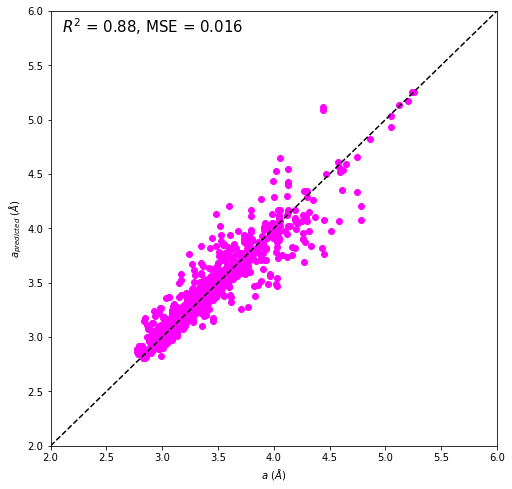

In [39]:
#xgbr.fit(x,y)
prediction_1 = xgbr.predict(X_predict_data_1)

r2_score = xgbr.score(X_predict_data_1, y_predict_data_1)
mse = mean_squared_error(y_predict_data_1, prediction_1)

f, ax = plt.subplots(figsize=(8, 8))
#sns.scatterplot(x=y_predict_data_1, y=prediction_1)
plt.plot(y_predict_data_1, prediction_1, 'o', color = "magenta")
#r2_score =  r2_score(y_predict_data_1, prediction_1)
plt.ylabel(r"$a_{predicted}$ ($\AA$)")
plt.xlabel(r"$a$ ($\AA$)")
plt.xlim([2, 6])
plt.ylim([2, 6])
plt.plot([2, 6], [2, 6], 'k--')
plt.annotate(r"$R^2$ = %.2f, MSE = %.3f" % (r2_score, mse), (2.1, 5.8), fontsize=15);

if savefigs==True:
    f.savefig("Figures/Prediction1_H", dpi = 1200, transparent = False, facecolor = 'white')

In [40]:
result = X_predict_data_1.copy()
result['a'] = y_predict_data_1
result['a_predicted'] = prediction_1
result.drop(['SG', 'Temp'], axis = 1, inplace = True)
#result.drop(['SG-156', 'SG-8', '0K', '1T', 'Phase', 'Temp'], axis = 1, inplace = True)
result['% error of a'] = (abs(prediction_1 - y_predict_data_1 ))*100/y_predict_data_1
display(result)

,c,C11,C12,a,a_predicted,% error of a
Material,,,,,,
Mn-Ti-Te-Se,15.975,69.13,4.33,3.4805,3.538563,1.668231
Si-Mn-S-O,22.141,244.71,84.34,3.0865,3.000497,2.786429
Hf-Mo-O-Te,19.284,267.12,52.37,3.3070,3.250557,1.706761
Hf-Ge-S-Se,14.265,68.31,12.40,3.6835,3.640032,1.180078
Pb-Mn-O-Se,18.737,126.53,50.09,3.3550,3.291253,1.900057
...,...,...,...,...,...,...
Pb-Ge-S-Te,11.861,36.87,-16.38,4.0395,4.171201,3.260335
Ba-Te-Zn-S,10.249,10.28,6.94,5.2415,5.256816,0.292205
Ge-Pb-Te-Se,10.545,37.61,16.58,4.4720,4.499371,0.612054


## End of Case Study